# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
# Your code here
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.shape

(6362620, 11)

In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
import seaborn as sns

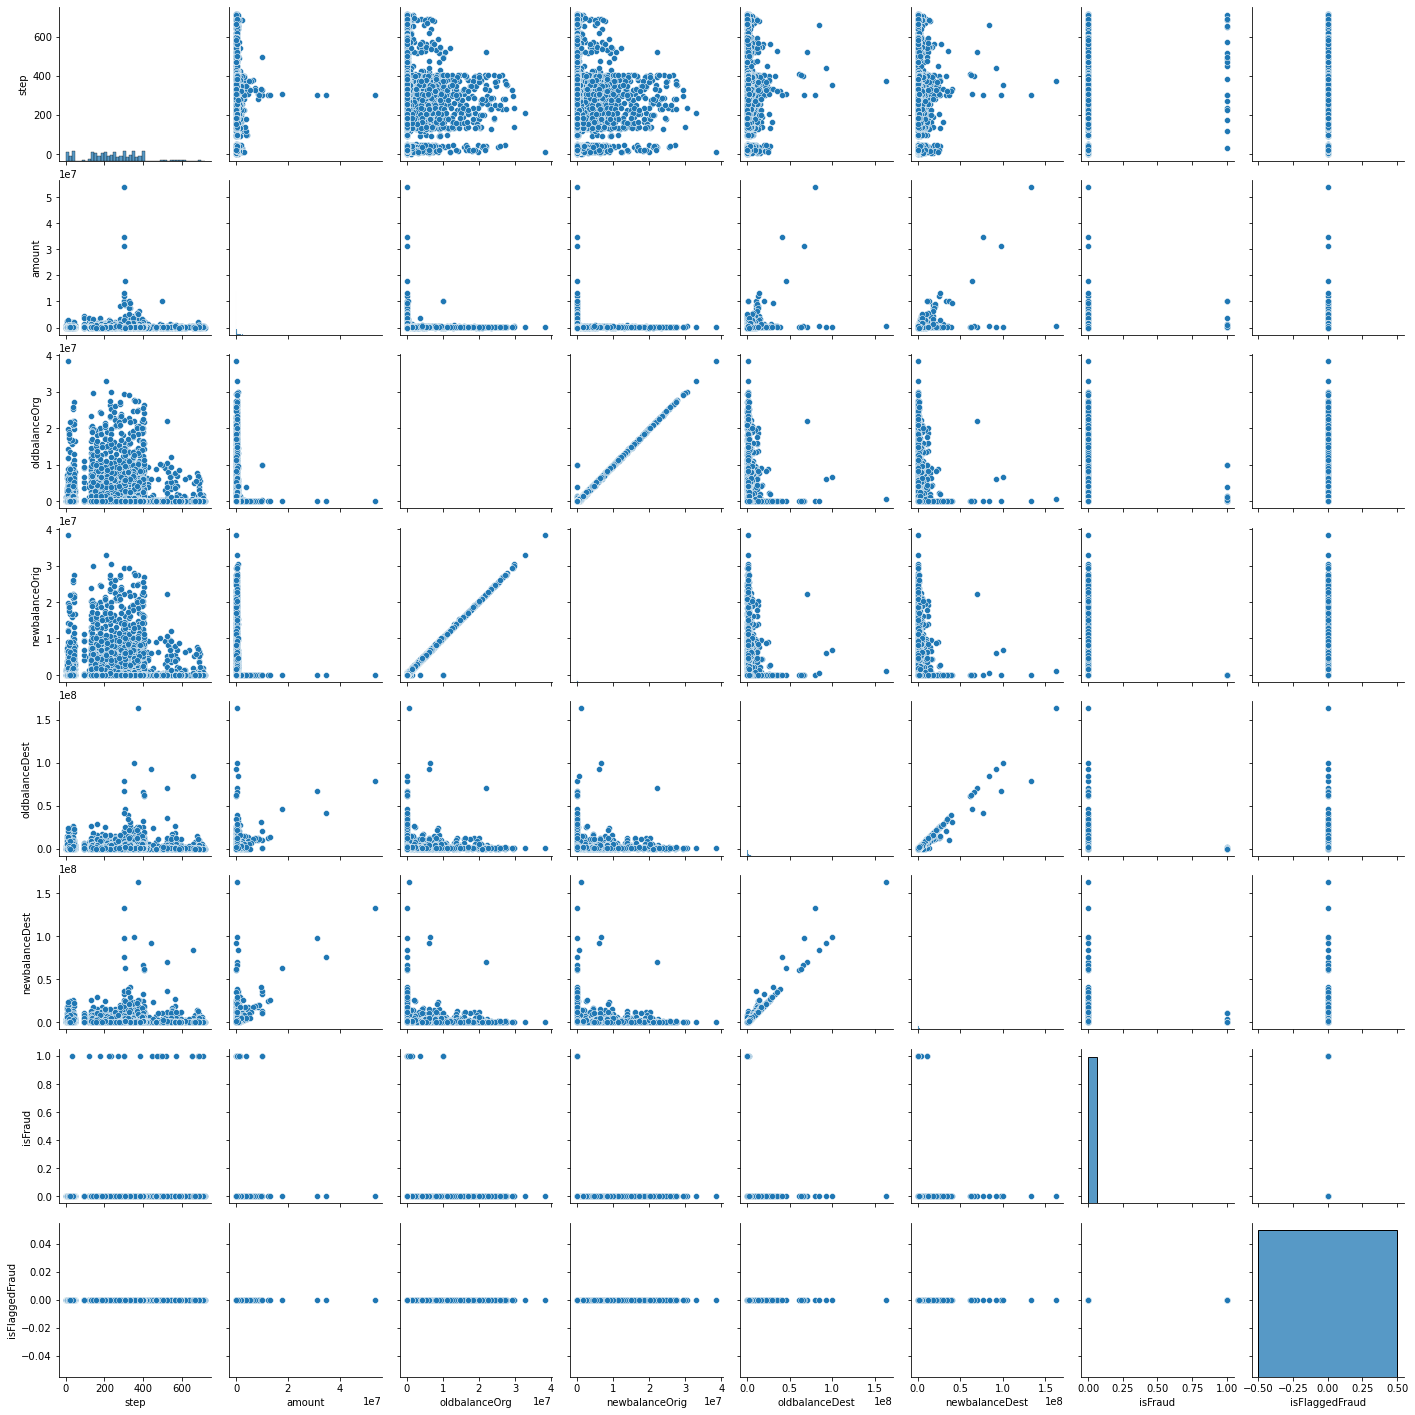

In [16]:
sns.pairplot(df.sample(10000))

<AxesSubplot:>

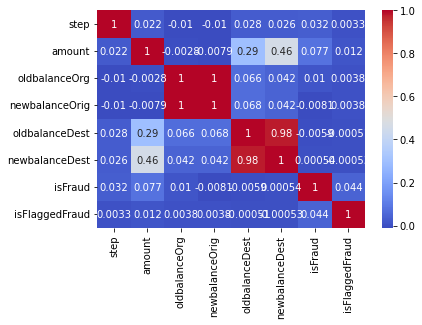

In [15]:
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

- if the the target is "isFraud" , amount variable seems to have the most correlation with it

### What is the distribution of the outcome? 

<AxesSubplot:xlabel='isFlaggedFraud', ylabel='count'>

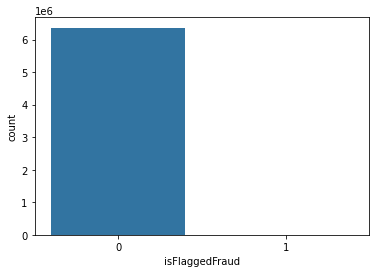

In [21]:
# Your response here
sns.countplot(data=df,x='isFlaggedFraud')

<AxesSubplot:xlabel='isFraud', ylabel='count'>

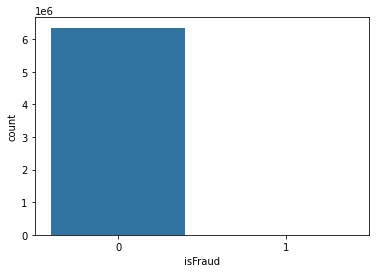

In [22]:
sns.countplot(data=df,x='isFraud')

- is clearly unbalanced towards 0

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [28]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [30]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [27]:
# Your code here
df['step'].value_counts()

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64

<AxesSubplot:>

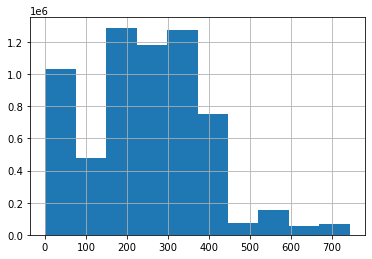

In [39]:
df['step'].hist()

In [40]:
# maybe we can discretize de variable?

In [41]:
from sklearn.preprocessing import KBinsDiscretizer

In [49]:
model = KBinsDiscretizer(n_bins=10,encode='ordinal')

In [51]:
df['step_encoded'] = model.fit_transform(df[['step']])

### Run a logisitc regression classifier and evaluate its accuracy.

In [78]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [79]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [87]:
df.head(1)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,step_encoded,CASH_IN_enc,CASH_OUT_enc,PAYMENT_enc,TRANSFER_enc,DEBIT_enc
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,0,0,1,0,0


In [80]:
df_dummies = pd.get_dummies(df.type)

In [81]:
df['CASH_IN_enc'] = df_dummies.CASH_IN
df['CASH_OUT_enc'] = df_dummies.CASH_OUT
df['PAYMENT_enc'] = df_dummies.PAYMENT
df['TRANSFER_enc'] = df_dummies.TRANSFER
df['DEBIT_enc'] = df_dummies.DEBIT

In [105]:
# a set assuming the target is "isFraud"

In [88]:
X1 = df.drop(['isFraud','type','nameOrig','nameDest'],axis=1)
y1 = df.isFraud

In [104]:
# a set assuming the target is isFlaggedFraud

In [89]:
X2 = df.drop(['isFlaggedFraud','type','nameOrig','nameDest'],axis=1)
y2 = df.isFlaggedFraud

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X1,y1,test_size=0.2)

In [91]:
model = LogisticRegression()

In [92]:
model.fit(X_train,y_train)

LogisticRegression()

In [96]:
y_pred = model.predict(X_test)

In [93]:
from sklearn.metrics import classification_report

In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270887
           1       0.33      0.39      0.36      1637

    accuracy                           1.00   1272524
   macro avg       0.67      0.69      0.68   1272524
weighted avg       1.00      1.00      1.00   1272524



In [99]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.2)

In [100]:
model = LogisticRegression()

In [101]:
model.fit(X_train,y_train)

LogisticRegression()

In [102]:
y_pred = model.predict(X_test)

In [103]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1272522
           1       0.00      0.00      0.00         2

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



### Now pick a model of your choice and evaluate its accuracy.

In [ ]:
# Your code here

### Which model worked better and how do you know?

In [2]:
# Your response here